In [24]:
from os import path

from datetime import datetime
import calendar


from ydata_synthetic.synthesizers.timeseries import TimeGAN

from DataPlot import *
import timegan_method.DataProcessor as dp
import timegan_method.PvModel as mdl
import timegan_method.DataEvaluation as de
from timegan_method.DataLoad import *

import numpy as np
from pvlib.location import Location

In [25]:
LOCATION = Location(40.3548, 18, 0, 0, 'Lecce')
PATH = "open-meteo-Lecce_new.csv"
SEQ_LENGHT = 24  # Dimensione della sliding window 24

data_df = Data(data_path=PATH, seq_len=SEQ_LENGHT)
cat_col = ["Mese"]
SAMPLES_N = len(data_df.data)

(17520, 9)


In [26]:
model = "timegan_method/model/final_model.pkl"
metadata = "timegan_method/model/final_meta.pkl"

if path.exists(model) and path.exists(metadata):
    synth = TimeGAN.load(model)
    processor = dp.DataProcessor().load_metadata(metadata)
    print()
    print(f"Model trained - {model}\nmetadata - {metadata}")
else:
    raise FileNotFoundError


Model trained - timegan_method/model/final_model.pkl
metadata - timegan_method/model/final_meta.pkl


In [27]:
generate = input('Generate a sequence? (y/n) ').lower().replace(" ", "")

if generate == 'n':
    file_toload = input("Saved results file:")
    if path.exists(file_toload):
        synth_results = np.load(file_toload)
    else:
        raise FileNotFoundError("Specific results file does not exist")
else:
    synth_results = synth.sample(SAMPLES_N)
    # Saving samples
    np.save(f"timegan_results.npy", synth_results)

Synthetic data generation: 100%|██████████| 137/137 [00:23<00:00,  5.71it/s]


### Synthetic samples

In [28]:
# Get the complete timeseries, by inverting preprocessing
synth_final = synth_results.reshape(-1, processor.col_number)
synth_final = processor.reverse_transform(synth_final)
synth_df = pd.DataFrame(synth_final, columns=processor.get_columns())

# Fixing dtypes
synth_df[processor.num_columns] = synth_df[processor.num_columns].apply(pd.to_numeric)

In [29]:
# SAMPLES WINDOWS TO PLOT
samples_to_plot = []
# Numero totale di righe nel dataframe
total_rows = len(synth_df)

m_resolution = int(24 * 60 / int((data_df.data.index[1] - data_df.data.index[0]).seconds / 60))

# Iterare attraverso il DataFrame a blocchi di m_resolution righe
for start in range(0, total_rows, m_resolution):
    # Verifica che ci siano abbastanza righe
    if start + m_resolution > total_rows:
        break  # Esce dal ciclo se non ci sono abbastanza righe per una nuova finestra

    # Estrai il blocco
    finestra = synth_df.iloc[start:start + m_resolution]
    finestra = finestra.reset_index(drop=True)

    samples_to_plot.append(finestra)


# EXTRACTING RANDOM DAY FRAMES
for plots in range(5):
    index = np.random.randint(len(samples_to_plot))
    plty_plot_dataframes([samples_to_plot[index][processor.num_columns]], title=f"Sample number {index}")

### Results filtering

In [30]:
# Finestre che corrispondono al pattern
finestre_valide = dp.extract_samples(real=data_df.data,synth=synth_df)

synth_tot = pd.concat(finestre_valide).reset_index(drop=True)
synth_tot["Mese"] = synth_tot["Mese"].apply(lambda x: datetime.strptime(x, '%B').month)
synth_tot = synth_tot.rename_axis("index").sort_values(by=["Mese", "index"])
synth_tot["Mese"] = synth_tot["Mese"].apply(lambda x: calendar.month_name[x])
# Resetting index order
synth_tot = synth_tot.reset_index(drop=True)

print(f"Samples found: {len(finestre_valide)}")

Extracting samples: 100%|██████████| 17536/17536 [00:08<00:00, 1998.56it/s]
Samples found: 426


In [36]:
pattern_to_plot = []
total_rows = len(synth_tot)
# Iterare attraverso il DataFrame a blocchi di 24 righe
for start in range(0, total_rows, m_resolution):
    # Verifica che ci siano abbastanza righe per una finestra completa di 24 ore
    if start + m_resolution > total_rows:
        break  # Esce dal ciclo se non ci sono abbastanza righe per una nuova finestra

    # Estrai il blocco di 24 righe
    finestra = synth_tot.iloc[start:start + m_resolution]
    finestra = finestra.reset_index(drop=True)
    pattern_to_plot.append(finestra)

plotted_pattern = []
for plots in range(5):
    index = np.random.randint(len(pattern_to_plot))
    plotted_pattern.append(pattern_to_plot[index])
    plty_plot_dataframes([pattern_to_plot[index][processor.num_columns]], title=f"Sample month: {pattern_to_plot[index].iloc[0]['Mese']}")

### PVLIB

In [32]:
from importlib import reload
reload(mdl)

<module 'timegan_method.PvModel' from 'D:\\SYNTETHIC_DATA_GEN\\TimeGAN\\timegan_method\\PvModel.py'>

In [33]:
panel = mdl.PVModel(location=LOCATION)

In [37]:
for sample in plotted_pattern:
    energy_sample = panel.run_model(sample=[sample])
    plty_plot_dataframes([energy_sample], title="Energy sample")

Generating energy data: 100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


Generating energy data: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Generating energy data: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


Generating energy data: 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


Generating energy data: 100%|██████████| 1/1 [00:00<00:00, 32.78it/s]


### Evaluation

Mixing: 100%|██████████| 17496/17496 [00:00<00:00, 2187810.59it/s]


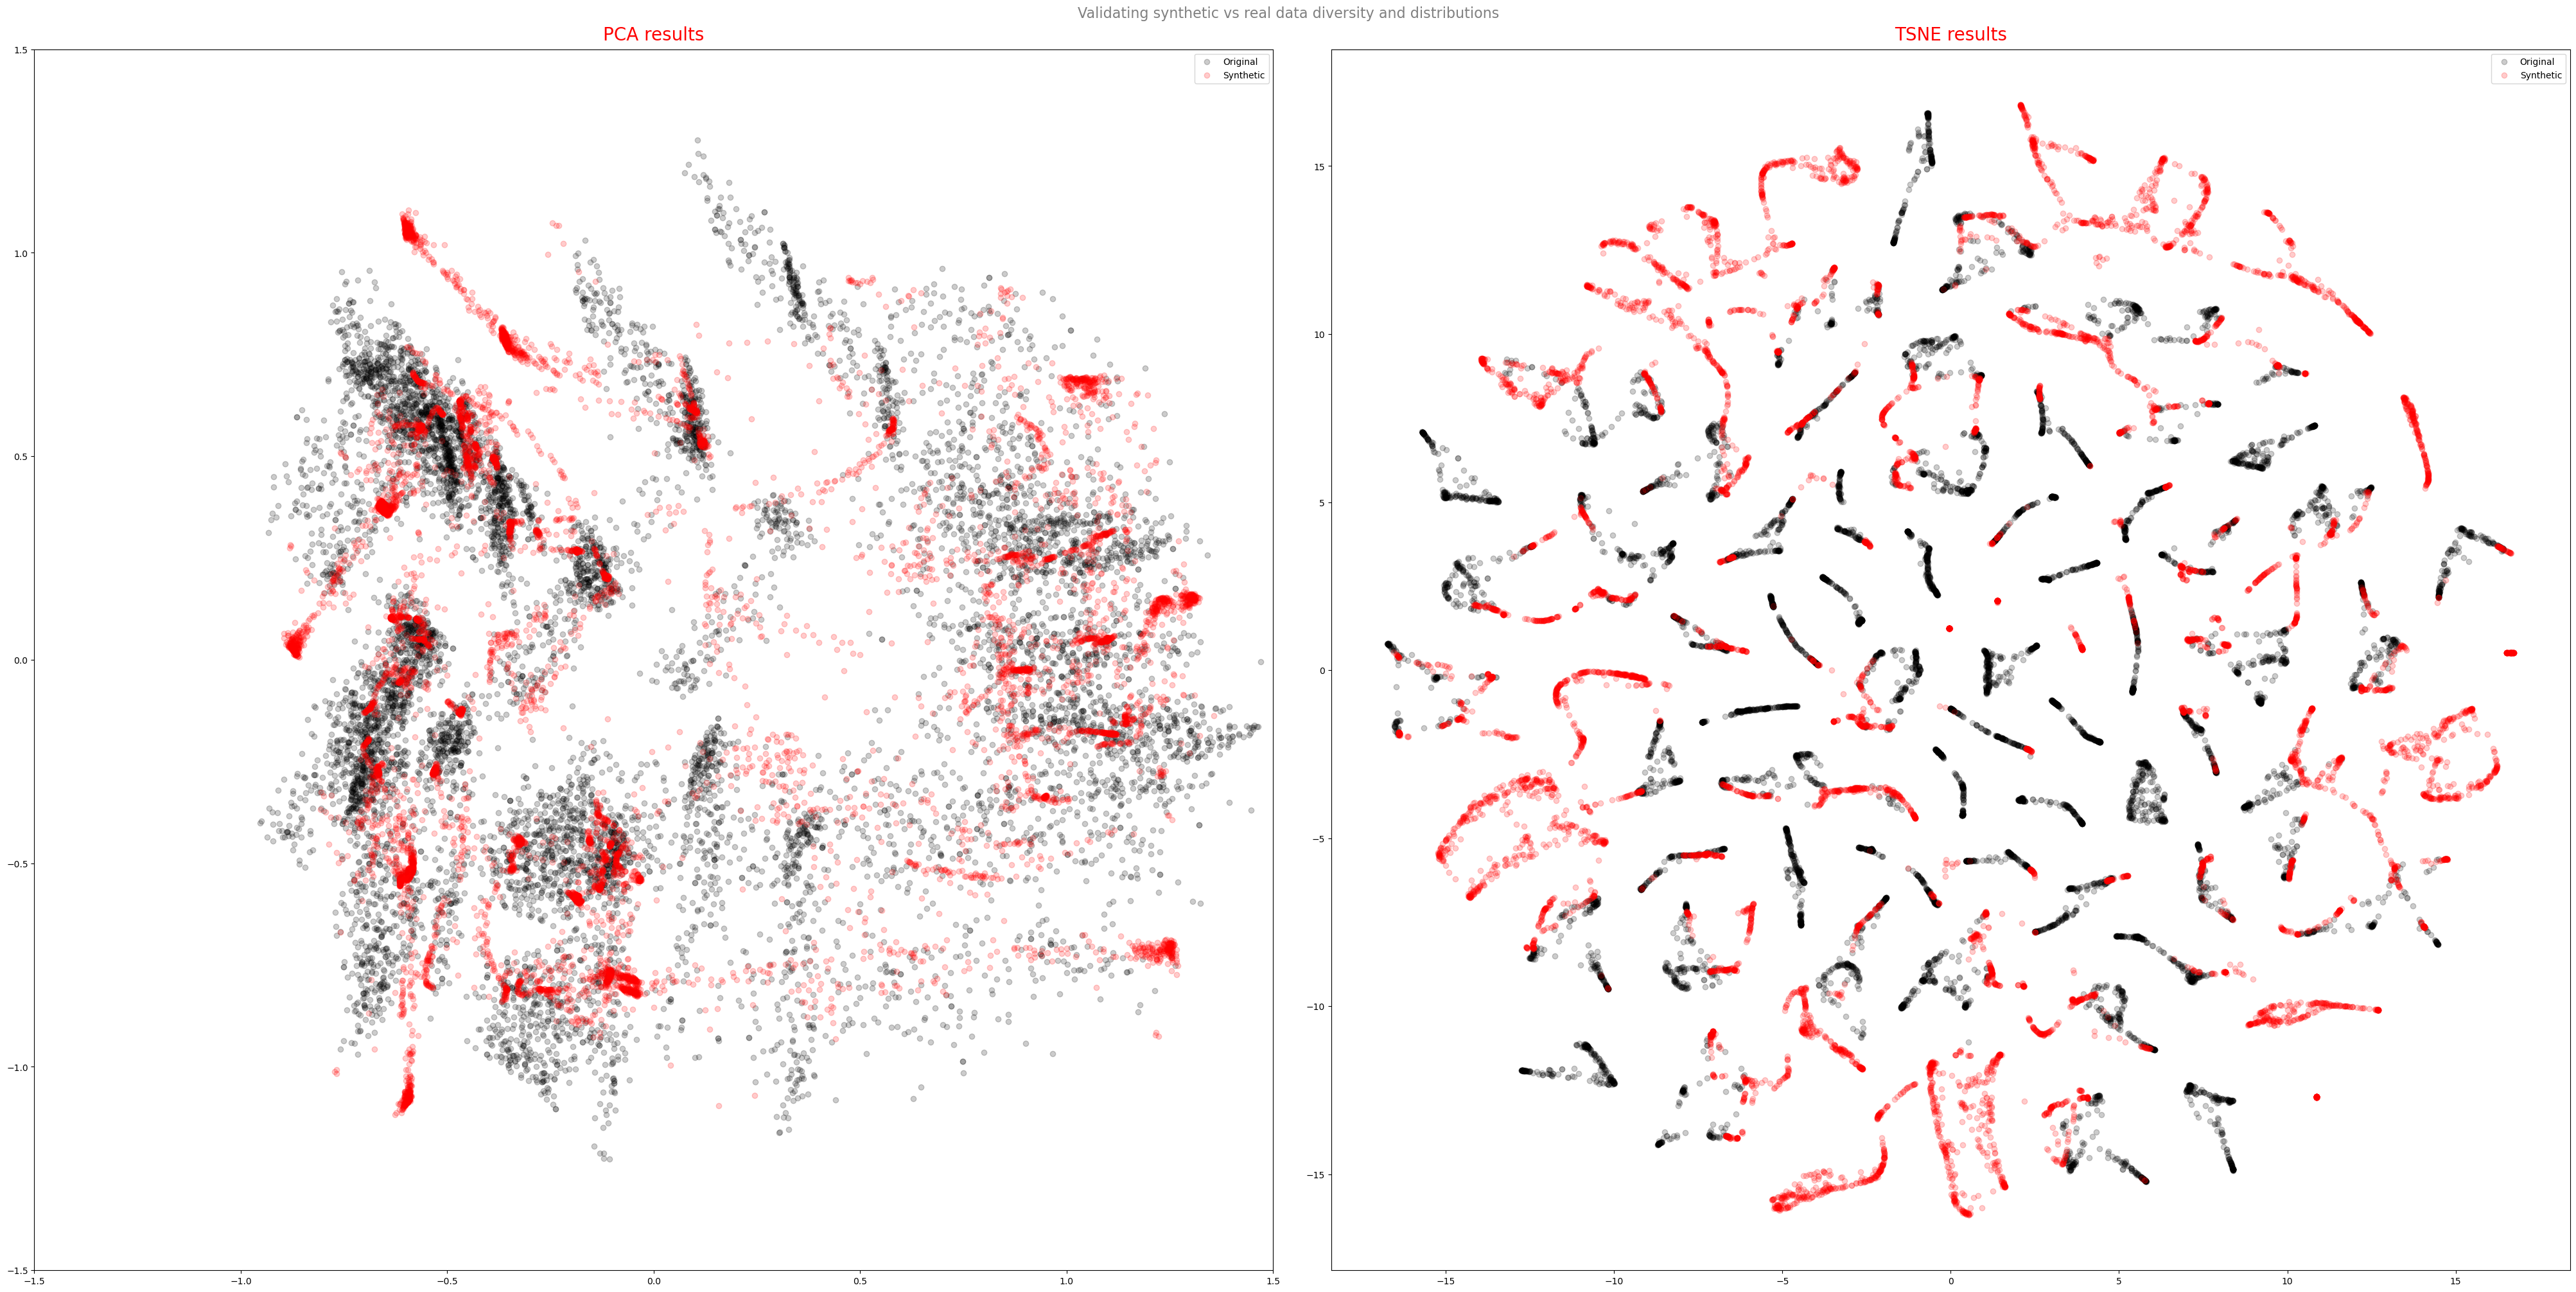

In [35]:
data = data_df.prepare_data(processor.num_columns, processor.cat_columns)
eval_res = de.DataEvaluation(data, synth_results, SEQ_LENGHT, 500)
eval_res.evaluate_data()